## **Model Prototyping**

This notebook builds and evaluates initial text classification models  
to detect spoiler vs non-spoiler reviews.

Baseline models tested:
- Multinomial Naive Bayes
- Logistic Regression


In [19]:
# import nltk
# nltk.download('punkt')
# nltk.download('punkt_tab')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import precision_recall_fscore_support
from nltk.tokenize import sent_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_feather("../data/preprocessed_reviews.feather")

### Adding Features
- `word_count`
- `has_spoiler_tag`
- `sentence_count`

In [3]:
df["word_count"] = df["review_text"].apply(len)
df["has_spoiler_tag"] = df["review_text"].apply(lambda x : "spoiler" in x)
df["review_text_str"] = df["review_text"].astype(str)
df["review_summary_str"] = df["review_summary"].astype(str)
df["full_text"] = df["review_summary_str"] + " " + df["review_text_str"]
df["sentence_count"] = df["review_text_str"].apply(lambda x: len(sent_tokenize(x)))

In [4]:
df["avg_sentence_length"] = df["word_count"] / (df["sentence_count"] + 1e-6)

### Splitting the data for training and testing

In [5]:
X = df[["full_text", "word_count", "has_spoiler_tag", "sentence_count", "avg_sentence_length"]]
y = df["is_spoiler"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_text = X_train["full_text"]
X_test_text = X_test["full_text"]
y_test = y_test.astype(str)

In [16]:
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])
print("Spoiler ratio (train):", y_train.value_counts(normalize=True))

Training samples: 459130
Testing samples: 114783
Spoiler ratio (train): is_spoiler
False    0.737027
True     0.262973
Name: proportion, dtype: float64


### Vectorizing the `full_text` column

In [6]:
# hash_vect = HashingVectorizer(n_features=50000, ngram_range=(1,2), alternate_sign=False)
# X_train_hash = hash_vect.transform(X_train_text)
# X_test_hash = hash_vect.transform(X_test_text)

tfidf_full = TfidfVectorizer(
    max_features=40000,
    ngram_range=(1,2),
    min_df=3,
    max_df=0.8,
    sublinear_tf=True,
    stop_words='english'
)

X_train_tfidf = tfidf_full.fit_transform(X_train_text)
X_test_tfidf = tfidf_full.transform(X_test_text)

In [7]:
keywords = ["plot twist", "ending", "spoiler", "dies", "surprise", "reveal", "betrayal", "twist", "revealed", "kill", "death", "betrays"]
tfidf_kw = TfidfVectorizer(vocabulary=keywords)
X_train_kw = tfidf_kw.fit_transform(X_train_text)
X_test_kw = tfidf_kw.transform(X_test_text)

### Putting everything together

In [8]:
X_train_numeric = X_train[["word_count", "has_spoiler_tag", "sentence_count", "avg_sentence_length"]].copy()

X_train_numeric["has_spoiler_tag"] = X_train_numeric["has_spoiler_tag"].astype(int)

X_test_numeric = X_test[["word_count", "has_spoiler_tag", "sentence_count", "avg_sentence_length"]].copy()
X_test_numeric["has_spoiler_tag"] = X_test_numeric["has_spoiler_tag"].astype(int)

X_train_combined = hstack([
    # X_train_hash,
    X_train_tfidf,
    X_train_kw,
    csr_matrix(X_train_numeric.values)
])

X_test_combined = hstack([
    # X_test_hash,
    X_test_tfidf,
    X_test_kw,
    csr_matrix(X_test_numeric.values)
])

## **Training with Naive Bayes**

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='f1')
grid.fit(X_train_combined, y_train)
print(grid.best_params_)

{'alpha': 1.0}


In [21]:
nb = MultinomialNB(alpha=grid.best_params_['alpha'])
nb.fit(X_train_combined, y_train)
nb_probs = nb.predict_proba(X_test_combined)[:, 1]

In [24]:
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred = (nb_probs >= t).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_test.map({'False':0,'True':1}), y_pred, average='binary', zero_division=np.nan)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1-Score: {best_f1:.4f}")


Best Threshold: 0.20
Best F1-Score: 0.5350


              precision    recall  f1-score   support

       False       0.86      0.70      0.77     84598
        True       0.44      0.68      0.54     30185

    accuracy                           0.69    114783
   macro avg       0.65      0.69      0.65    114783
weighted avg       0.75      0.69      0.71    114783

[[58813 25785]
 [ 9743 20442]]


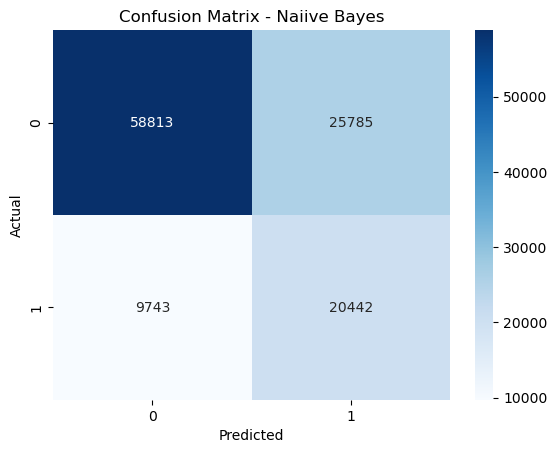

In [27]:
y_pred = np.where(nb_probs > best_threshold, 'True', 'False')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naiive Bayes")
plt.show()

## **Training with Logistic Regression**

In [28]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='saga',
    n_jobs=-1
)
lr.fit(X_train_combined, y_train)
lr_probs = lr.predict_proba(X_test_combined)[:, 1]

In [ ]:
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred = (lr_probs >= t).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_test.map({'False':0,'True':1}), y_pred, average='binary', zero_division=np.nan)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1-Score: {best_f1:.4f}")


Best Threshold: 0.42
Best F1-Score: 0.5002


              precision    recall  f1-score   support

       False       0.85      0.63      0.72     84598
        True       0.40      0.68      0.50     30185

    accuracy                           0.64    114783
   macro avg       0.62      0.65      0.61    114783
weighted avg       0.73      0.64      0.66    114783

[[53416 31182]
 [ 9718 20467]]


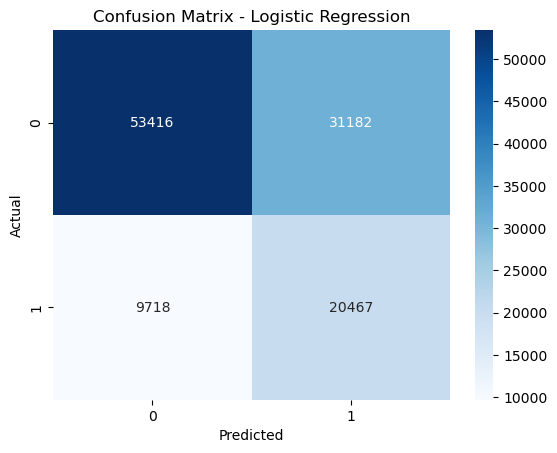

In [30]:
y_pred = np.where(lr_probs > best_threshold, 'True', 'False')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### **Comparing both the results**

In [31]:
import pandas as pd

results = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression'],
    'Precision (Spoiler)': [0.44, 0.40],
    'Recall (Spoiler)': [0.68, 0.68],
    'F1 (Spoiler)': [0.54, 0.50],
    'Accuracy': [0.69, 0.64],
    'Macro F1': [0.65, 0.61]
})

results


,Model,Precision (Spoiler),Recall (Spoiler),F1 (Spoiler),Accuracy,Macro F1
0,Naive Bayes,0.44,0.68,0.54,0.69,0.65
1,Logistic Regression,0.40,0.68,0.50,0.64,0.61
